# This notebook shows the optimization to find the best spectral bands for unmixing a set of endmember spectra from a hyperspectral cube.

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


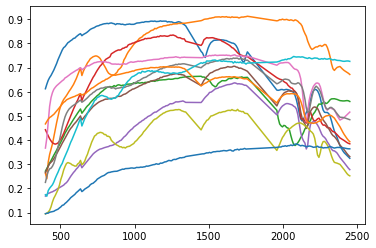

'\n# upper left corner\narea_1 = hypercube[:20,:20,:]\nmap_1 = a_map[:20,:20,:]\n\n#centre\narea_2 = hypercube[100:120,100:120,:]\nmap_2 = a_map[:20,:20,:]\n\n#endmember 6\narea_3 = hypercube[100:120,130:150,:]\nmap_3 = a_map[100:120,130:150,:]\n\n#endmember 7\narea_4 = hypercube[230:250,100:120,:]\nmap_4 = a_map[230:250,100:120,:]\n\n\ndata_1 = np.append(area_1, area_2,axis = 0)\ndata_map_1 = np.append(map_1, map_2, axis = 0)\n\ndata_2 = np.append(area_3, area_4,axis = 0)\ndata_map_2 = np.append(map_3, map_4, axis = 0)\n\nhypercube = np.append(data_1, data_2,axis = 1)\na_map = np.append(data_map_1, data_map_2,axis = 1)\n\n'

In [2]:
dataset = "cuprite"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

figure(1)
plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])
plot(wavelength, spectra[3])
plot(wavelength, spectra[4])
plot(wavelength, spectra[5])
plot(wavelength, spectra[6])
plot(wavelength, spectra[7])
plot(wavelength, spectra[8])
plot(wavelength, spectra[9])
plot(wavelength, spectra[10])
plot(wavelength, spectra[11])
plt.show()

'cut it first, my computer cannot run the whole dataset, need to used online GPU'

"""
# upper left corner
area_1 = hypercube[:20,:20,:]
map_1 = a_map[:20,:20,:]

#centre
area_2 = hypercube[100:120,100:120,:]
map_2 = a_map[:20,:20,:]

#endmember 6
area_3 = hypercube[100:120,130:150,:]
map_3 = a_map[100:120,130:150,:]

#endmember 7
area_4 = hypercube[230:250,100:120,:]
map_4 = a_map[230:250,100:120,:]


data_1 = np.append(area_1, area_2,axis = 0)
data_map_1 = np.append(map_1, map_2, axis = 0)

data_2 = np.append(area_3, area_4,axis = 0)
data_map_2 = np.append(map_3, map_4, axis = 0)

hypercube = np.append(data_1, data_2,axis = 1)
a_map = np.append(data_map_1, data_map_2,axis = 1)

"""

In [3]:
def create_hypercube(a_map, spectra):
 
    '''
    Generate a hypercube.
    
    Inputs:
        a_map (N*M, L)
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.        
    
    N represents N*M!
    
    Output:
        hypercube (N*M, Q)
    '''

    N,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,i],spectra[i]).reshape((N,Q))
    
    return hypercube

# Start ML Bolck

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras import layers
from keras import models

In [5]:
N,M,P = hypercube.shape
_,_,Q = a_map.shape

In [6]:

x_train,x_test,y_train,y_test = train_test_split(hypercube.reshape(N*M,P), a_map.reshape(N*M,Q), test_size=0.8)

In [7]:
x_train.shape

(9500, 188)

In [8]:
y_train.shape

(9500, 12)

In [9]:
x_test.shape

(38000, 188)

In [10]:
y_test.shape

(38000, 12)

In [11]:
#savetxt("../Machine_Learning_ref_data/x.txt",X)

In [12]:
#savetxt("../Machine_Learning_ref_data/y.txt",Y)

In [13]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(12,'softmax')
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [14]:
model = get_compiled_model()

In [15]:
history = model.fit(x_train,y_train, epochs=60)

Epoch 1/60
297/297 [==============================] - 0s 777us/step - loss: 0.7346 - accuracy: 0.6501
Epoch 2/60
297/297 [==============================] - 0s 819us/step - loss: 0.7345 - accuracy: 0.8073
Epoch 3/60
297/297 [==============================] - 0s 762us/step - loss: 0.7345 - accuracy: 0.8236
Epoch 4/60
297/297 [==============================] - 0s 776us/step - loss: 0.7345 - accuracy: 0.8302
Epoch 5/60
297/297 [==============================] - 0s 788us/step - loss: 0.7344 - accuracy: 0.8407
Epoch 6/60
297/297 [==============================] - 0s 755us/step - loss: 0.7344 - accuracy: 0.8859
Epoch 7/60
297/297 [==============================] - 0s 806us/step - loss: 0.7344 - accuracy: 0.8985
Epoch 8/60
297/297 [==============================] - 0s 831us/step - loss: 0.7344 - accuracy: 0.9076
Epoch 9/60
297/297 [==============================] - 0s 780us/step - loss: 0.7344 - accuracy: 0.9051
Epoch 10/60
297/297 [==============================] - 0s 785us/step - loss: 0.734

In [16]:
loss,acc = model.evaluate(x_test,y_test, verbose=1)

1188/1188 [==============================] - 1s 437us/step - loss: 0.7344 - accuracy: 0.9461


In [17]:
print(loss,acc)

0.734376072883606 0.946052610874176


In [18]:
#model.save('my_model_amazing_acc_0.99.h5')

In [19]:
# model=load_model("my_model_.hdf5")

In [20]:
training_loss = history.history['loss']

In [21]:
training_acc = history.history['accuracy']

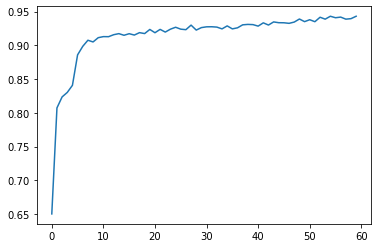

In [22]:
plot(training_acc)

Text(0.5, 1.0, 'a_map noise reduction using NN (Cuprite)')

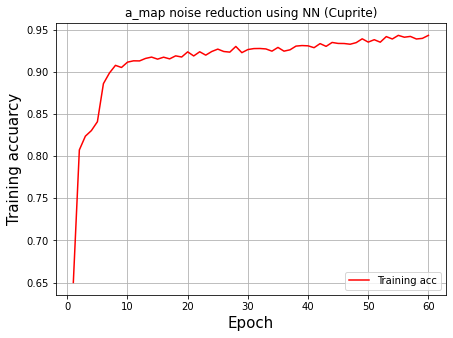

In [24]:
x_axis = range(1,61)

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

ax.plot (x_axis,training_acc,'r',label = 'Training acc')

ax.grid()
ax.legend(loc=4)

ax.set_xlabel('Epoch',fontsize=15)
ax.set_ylabel("Training accuarcy",fontsize=15)
title('a_map noise reduction using NN (Cuprite)')